## Comparing different LLM's to solve the Kaggle Challenge

In [8]:
from dotenv import load_dotenv
load_dotenv()
from openai import OpenAI
from transformers import pipeline
import os
import huggingface_hub
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import re
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
from matplotlib.widgets import Slider
from sklearn.metrics import cohen_kappa_score

huggingface_username = 'HSLU-AICOMP-LearningAgencyLab'
competition = 'learning-agency-lab-automated-essay-scoring-2'

open_api_model = "gpt-4o-mini"
# huggingface_models = ["nvidia/Mistral-NeMo-Minitron-8B-Instruct"]
huggingface_models = []

huggingface_hub.login(token=os.getenv('HUGGINGFACE_TOKEN'))

train = load_dataset(f"{huggingface_username}/{competition}", split="train")
eval = load_dataset(f"{huggingface_username}/{competition}", split="eval")
test = load_dataset(f"{huggingface_username}/{competition}", split="test")

client = OpenAI()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/leonkrug/.cache/huggingface/token
Login successful


In [2]:
# OpenAI GPT example
def query_openai(prompt, role_definition):
    completion = client.chat.completions.create(
        model=open_api_model,
        messages=[
            {"role": "system", "content": role_definition},
            {
                "role": "user",
                "content": prompt
            }
        ]
    )

    return completion.choices[0].message

# Hugging Face example
def init_huggingface_model(model_name):
    device = 0 if torch.cuda.is_available() else -1
    # Load the model once
    model = pipeline('text-generation', model=model_name, device=device, torch_dtype=torch.float16)
    return model

# Query the model (pass the initialized model instead of reinitializing it)
def query_huggingface(prompt, role_definition, generator):
    # Combine the role definition with the prompt
    combined_prompt = role_definition + "\n\n" + prompt

    # Generate response using the pre-initialized Hugging Face model
    response = generator(combined_prompt, max_new_tokens=50, num_return_sequences=1)
    
    # Return the generated text
    return response[0]['generated_text']

def get_role_definition(examples_by_score: dict):
    return f"""
        You are tasked with scoring a student essay based on the following rubric, where scores range from 1 to 6. 
        The score should be based on the essay's mastery, development of ideas, use of evidence, organization, language use, and grammar. 
        Use the detailed rubric below to guide your assessment:

        Rubric:

        Score of 6: Mastery, effective development of ideas, clear evidence, smooth organization, strong vocabulary, minimal errors.
        Score of 5: Strong performance, good development, mostly clear evidence, well-organized, minor errors.
        Score of 4: Adequate performance, some inconsistencies in ideas, reasonable evidence, generally organized, some errors.
        Score of 3: Developing, weak development, inadequate evidence, limited organization, noticeable errors.
        Score of 2: Weak performance, vague ideas, insufficient evidence, poorly organized, frequent errors.
        Score of 1: Very little mastery, no development of ideas, incoherent, severe grammar issues.

        Examples of each score:

        Score 6 Examples:
        {chr(10).join(examples_by_score[6])}

        Score 5 Examples:
        {chr(10).join(examples_by_score[5])}

        Score 4 Examples:
        {chr(10).join(examples_by_score[4])}

        Score 3 Examples:
        {chr(10).join(examples_by_score[3])}

        Score 2 Examples:
        {chr(10).join(examples_by_score[2])}

        Score 1 Examples:
        {chr(10).join(examples_by_score[1])}

        Returns the score of the essay based on the rubric in this format (score_of_essay needs to replaced with the actual score. Also, please add the :: before and after the result): "The essay is scored as a ::score_of_essay::"
    """

In [3]:
# Initialize an empty dictionary to hold the examples by score
examples_by_score = {}

# Track the essay_ids used in the examples_by_score dictionary
used_essay_ids = set()

# Define the number of examples you want per score
n_examples_per_score = 4

# Populate the examples_by_score dictionary
for score in range(1, 7):  # Scores are from 1 to 6
    # Filter examples with the specific score
    score_examples = train.filter(lambda x: x['score'] == score)
    
    # Select the first N examples from the filtered set, up to n_examples_per_score
    selected_examples = score_examples.select(range(min(n_examples_per_score, len(score_examples))))
    
    # Add the selected essay IDs to the used_essay_ids set
    used_essay_ids.update(selected_examples['essay_id'])
    
    # Concatenate the full texts of these examples into a single string
    examples_by_score[score] = "\n\n".join(selected_examples['full_text'])

# Now, let's get 10 random examples from the train set that are not in used_essay_ids
remaining_examples = train.filter(lambda x: x['essay_id'] not in used_essay_ids)

# Generate the role definition using the examples_by_score dictionary
role_definition = get_role_definition(examples_by_score)



# Define your prompt
prompt = f"""
Essay: {remaining_examples[0]['full_text']}

Based on the provided rubric, please assign a score between 1 and 6 for the following essay. The response should follow this format exactly, and only this format, with the score replacing `score_of_essay`:

"The essay is scored as a ::score_of_essay::"

Make sure to replace `score_of_essay` with the actual number.
Essay:
<essay_text_here>
"""

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13845 [00:00<?, ? examples/s]

In [4]:
# # Query each LLM
openai_response = query_openai(prompt, role_definition)
print(f"{open_api_model} Response:", openai_response.content)

# Initialize all Hugging Face models once
huggingface_generators = [init_huggingface_model(model) for model in huggingface_models]

for j, huggingface_model in enumerate(huggingface_generators):
    # Get the response from the Hugging Face model
    huggingface_response = query_huggingface(prompt, role_definition, huggingface_model)
    
    # Print the model name and response
    print(f"{huggingface_models[j]} Response:", huggingface_response)

print(f"Real score from dataset: {remaining_examples[0]['score']}")

gpt-4o-mini Response: "The essay is scored as a ::4::"
Real score from dataset: 3


Example 1:
  OpenAI Predicted Score: 3
  Actual Score: 1
----------------------------------------
Example 2:
  OpenAI Predicted Score: 4
  Actual Score: 6
----------------------------------------
Example 3:
  OpenAI Predicted Score: 4
  Actual Score: 4
----------------------------------------
Example 4:
  OpenAI Predicted Score: 3
  Actual Score: 5
----------------------------------------
Example 5:
  OpenAI Predicted Score: 4
  Actual Score: 2
----------------------------------------
Example 6:
  OpenAI Predicted Score: 3
  Actual Score: 3
----------------------------------------


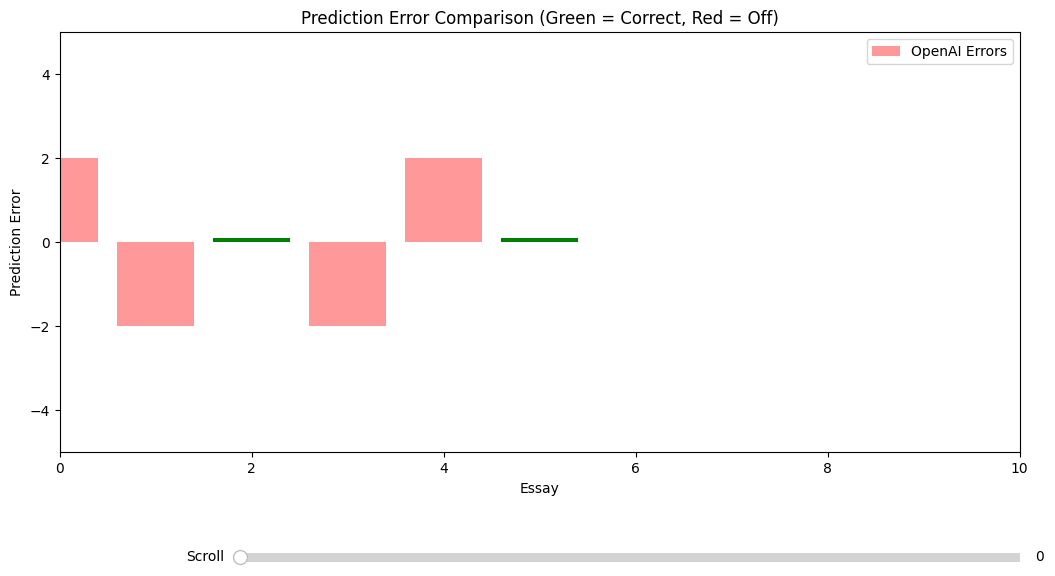

OpenAI Model QWK: 0.16%


In [5]:
# Function to calculate Quadratic Weighted Kappa
def calculate_qwk(predicted_scores, actual_scores):
    return cohen_kappa_score(actual_scores, predicted_scores, weights='quadratic')

# Extract the predicted score from the response content
def extract_predicted_score(response):
    try:
        # Try to extract from 'content', 'message', or raw response
        if hasattr(response, 'content'):
            text = response.content
        elif hasattr(response, 'message'):
            text = response.message
        else:
            text = response

        # Use regex to find the number between :: and ::
        match = re.search(r'::(\d+)::', text)
        
        if match:
            score = int(match.group(1))  # Extract the number found between the :: tags
            return score
        else:
            print(f"No score found in response")
            return None
    except Exception as e:
        print(f"Error extracting score: {e}")
        return None

# Function to calculate the color based on prediction accuracy
def get_color(predicted, actual):
    if predicted is None or actual is None:
        return 'gray'  # Use gray for missing data
    if predicted == actual:
        return 'green'
    else:
        # More off = more red
        error = abs(predicted - actual)
        return (1, 1 - error / 5, 1 - error / 5)  # RGB values for red intensity

# Function to plot the results using error bars with colors
def plot_results_errorbar(predicted_scores_openai, predicted_scores_huggingface, actual_scores, huggingface_models):
    num_essays = len(actual_scores)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # X-axis values: one for each essay
    essays = np.arange(num_essays)
    
    # Error bars for OpenAI model
    errors_openai = []
    colors_openai = []
    
    # Modify error values to make green bars for correct predictions visible
    for pred, actual in zip(predicted_scores_openai, actual_scores):
        if pred is None or actual is None:
            errors_openai.append(0)  # Assign 0 error for missing data
        elif pred == actual:
            # Slight non-zero height for correct predictions to make them visible
            errors_openai.append(0.1)
        else:
            # Append the actual error for incorrect predictions
            errors_openai.append(pred - actual)
        
        # Append corresponding color
        colors_openai.append(get_color(pred, actual))
    
    # Plot error bars for OpenAI model
    ax.bar(essays, errors_openai, color=colors_openai, label='OpenAI Errors')

    # Error bars for Hugging Face models
    for i, model_scores in enumerate(predicted_scores_huggingface):
        errors_huggingface = []
        colors_huggingface = []
        
        for pred, actual in zip(model_scores, actual_scores):
            if pred is None or actual is None:
                errors_huggingface.append(0)  # Assign 0 error for missing data
            elif pred == actual:
                errors_huggingface.append(0.1)  # Same adjustment for green visibility
            else:
                errors_huggingface.append(pred - actual)
            colors_huggingface.append(get_color(pred, actual))
        
        ax.bar(essays, errors_huggingface, color=colors_huggingface, alpha=0.5, label=f'Hugging Face: {huggingface_models[i]}')

    # Add a legend
    ax.legend()

    # Set the labels and title
    ax.set_xlabel("Essay")
    ax.set_ylabel("Prediction Error")
    ax.set_title("Prediction Error Comparison (Green = Correct, Red = Off)")

    # Y-axis ticks for score error (-5 to +5)
    ax.set_ylim([-5, 5])

    # Add a slider to scroll through the essays
    ax_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Scroll', 0, num_essays - 1, valinit=0, valstep=1)

    # Function to update the plot view when slider changes
    def update(val):
        pos = slider.val
        ax.set_xlim([pos, pos + 10])  # Show 10 essays at a time
        fig.canvas.draw_idle()

    # Attach the update function to the slider
    slider.on_changed(update)

    # Initialize the plot view (first 10 essays)
    ax.set_xlim([0, 10])

    # Adjust layout manually instead of using tight_layout
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

    # Show the plot
    plt.show()

def query_models_parallel(prompt, role_definition, openai_model, huggingface_models, max_workers=10):
    results = {}

    def query_openai_model():
        openai_response = query_openai(prompt, role_definition)
        return 'OpenAI', extract_predicted_score(openai_response)

    def query_huggingface_model(model_name, huggingface_model):
        huggingface_response = query_huggingface(prompt, role_definition, huggingface_model)
        return model_name, extract_predicted_score(huggingface_response)

    # Start a thread pool with more workers
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        # Submit OpenAI model query to the thread pool
        futures.append(executor.submit(query_openai_model))
        # Submit Hugging Face model queries to the thread pool
        for model_name, huggingface_model in huggingface_models.items():
            futures.append(executor.submit(query_huggingface_model, model_name, huggingface_model))

        # Gather the results
        for future in as_completed(futures):
            model_name, predicted_score = future.result()
            results[model_name] = predicted_score

    return results

def run_experiments(num_examples, huggingface_models, max_workers=10):
    # Determine the minimum number of essays per score (10% of num_examples)
    min_per_score = max(1, num_examples // 10)

    # Create a dictionary to hold essays by score
    essays_by_score = defaultdict(list)
    
    # Populate the dictionary with essays grouped by their score
    for essay in remaining_examples:
        essays_by_score[essay['score']].append(essay)
    
    # Ensure that each score has at least `min_per_score` examples
    selected_essays = []
    for score in range(1, 7):  # Scores range from 1 to 6
        available_essays = essays_by_score[score]
        if len(available_essays) < min_per_score:
            print(f"Not enough essays for score {score}, using {len(available_essays)} examples.")
        selected_essays.extend(random.sample(available_essays, min(min_per_score, len(available_essays))))
    
    # Randomly sample the remaining essays to reach num_examples
    remaining_needed = num_examples - len(selected_essays)
    if remaining_needed > 0:
        other_essays = [essay for essay in remaining_examples if essay not in selected_essays]
        selected_essays.extend(random.sample(other_essays, remaining_needed))
    
    # Shuffle the selected essays
    random.shuffle(selected_essays)

    # Lists to store the predicted scores and actual scores
    predicted_scores_openai = []
    predicted_scores_huggingface = {model: [] for model in huggingface_models}  # Dict to store scores for each model
    actual_scores = []

    # Initialize Hugging Face models once
    huggingface_generators = {model: init_huggingface_model(model) for model in huggingface_models}

    # Loop through the selected essays
    for i, essay in enumerate(selected_essays):
        prompt = essay['full_text']
        actual_score = essay['score']

        # Run queries in parallel for the current essay
        model_predictions = query_models_parallel(prompt, role_definition, 'OpenAI', huggingface_generators, max_workers)

        # Store the OpenAI predicted score
        predicted_scores_openai.append(model_predictions['OpenAI'])

        # Store Hugging Face predicted scores
        for model_name, predicted_score in model_predictions.items():
            if model_name != 'OpenAI':
                predicted_scores_huggingface[model_name].append(predicted_score)

        # Store the actual score
        actual_scores.append(actual_score)

        # Print results for each iteration
        print(f"Example {i + 1}:")
        print(f"  OpenAI Predicted Score: {model_predictions['OpenAI']}")
        for model_name, score in model_predictions.items():
            if model_name != 'OpenAI':
                print(f"  {model_name} Predicted Score: {score}")
        print(f"  Actual Score: {actual_score}")
        print("-" * 40)

    # After the loop, plot the results
    plot_results_errorbar(predicted_scores_openai, list(predicted_scores_huggingface.values()), actual_scores, list(huggingface_models))

    # Calculate and print accuracy for OpenAI model
    openai_qwk = calculate_qwk(predicted_scores_openai, actual_scores)
    print(f"OpenAI Model QWK: {openai_qwk:.2f}%")

    # Calculate and print accuracy for each Hugging Face model
    for model_name in huggingface_models:
        hf_qwk = calculate_qwk(predicted_scores_huggingface[model_name], actual_scores)
        print(f"Hugging Face Model ({model_name}) QWK: {hf_qwk:.2f}%")


# Set the number of examples you want to try and pass the models
num_examples_to_try = 1
run_experiments(num_examples_to_try, huggingface_models)

In [16]:
def run_experiments_on_eval_set_log_to_file(eval_set, start_index=0, output_file=".../src/evaluation/llm_baseline_evaluation_results.csv"):
    # Open the output file in append mode to ensure data is saved line by line
    with open(output_file, 'a') as f:
        # If file is empty, write the header
        if f.tell() == 0:
            f.write("index,essayId,actualScore,openAIPredictedScore,scoreOffset\n")

        # Loop through each essay in the test set
        for idx, essay in enumerate(eval_set):
            prompt = essay['full_text']
            actual_score = essay['score']
            essay_id = essay['essay_id'] if 'essay_id' in essay else idx + start_index  # Use essay ID if available, otherwise use adjusted index

            # Query OpenAI model for prediction
            openai_predicted_score = query_models_parallel(prompt, role_definition, 'OpenAI', {}, max_workers=1).get('OpenAI')

            # Calculate score offset, handling the case where openai_predicted_score is None
            score_offset = openai_predicted_score - actual_score if openai_predicted_score is not None else None

            # Write the result to the file
            f.write(f"{idx + start_index},{essay_id},{actual_score},{openai_predicted_score},{score_offset}\n")
            f.flush()  # Flush the write buffer to ensure data is saved immediately

            # Print the result to console for tracking (optional)
            print(f"{idx + start_index},{essay_id},{actual_score},{openai_predicted_score},{score_offset}")

    print(f"Results written to {output_file}")

# Select a subset from index 2389 to the end
eval_subset = eval.select(range(2389, len(eval)))
run_experiments_on_eval_set_log_to_file(eval_subset, start_index=2389)


2389,bde5adf,3,5,2
2390,2feed4e,3,2,-1
2391,c2d5fa5,3,3,0
2392,308be53,5,3,-2
2393,1d9859e,2,3,1
2394,e965607,3,4,1
2395,ca7fb0e,3,3,0
2396,b75e1ba,4,5,1
2397,0f7aadf,3,3,0
2398,57c88d2,3,3,0
2399,51a4fb0,3,2,-1
2400,9c16b65,2,3,1
2401,3443062,2,4,2
2402,baede82,2,3,1
2403,8a5aed7,1,2,1
2404,4a35d90,3,3,0
2405,e2f214c,3,3,0
2406,3755a66,4,4,0
2407,569a513,3,3,0
2408,5e16b0a,3,2,-1
2409,ee4f643,2,3,1
2410,13a8ba8,3,3,0
2411,a95300b,3,3,0
2412,2a847b0,3,2,-1
2413,95285d8,4,3,-1
2414,f7c7aeb,4,3,-1
2415,8461f4b,3,4,1
2416,0539a44,2,3,1
2417,8628ef4,4,3,-1
2418,0870f09,3,4,1
2419,58ef980,3,2,-1
2420,e9701ba,5,4,-1
2421,a26438e,1,2,1
2422,40b5365,4,5,1
2423,5688842,4,3,-1
2424,1831d64,4,4,0
2425,6db3435,2,3,1
2426,1c80539,1,2,1
2427,23ed908,3,2,-1
2428,b6d1b2a,2,3,1
2429,44ce55e,5,3,-2
2430,babf897,2,3,1
2431,3d2d66c,2,3,1
2432,e386e14,1,3,2
2433,1a8c6b7,2,3,1
2434,9fa048b,2,4,2
2435,ff4c9d0,2,3,1
2436,9fc7cec,2,3,1
2437,e092b77,2,3,1
2438,f0cb8d2,2,3,1
2439,cafe815,2,2,0
2440,e2b69b6,3,3,0

In [17]:
import pandas as pd

def calculate_qwk_from_csv(filename: str) -> float:
    """
    Calculate the Quadratic Weighted Kappa (QWK) metric from a CSV file.

    Parameters:
    - filename: str, path to the CSV file containing 'actualScore' and 'openAIPredictedScore' columns.

    Returns:
    - float, the QWK score.
    """
    # Load the CSV file
    df = pd.read_csv(filename)

    # Ensure required columns are present
    if 'actualScore' not in df.columns or 'openAIPredictedScore' not in df.columns:
        raise ValueError("CSV file must contain 'actualScore' and 'openAIPredictedScore' columns.")

    # Calculate QWK using sklearn's cohen_kappa_score with 'quadratic' weights
    qwk_score = cohen_kappa_score(df['actualScore'], df['openAIPredictedScore'], weights='quadratic')

    return qwk_score

qwk_result = calculate_qwk_from_csv('../src/evaluation/llm_baseline_evaluation_results.csv')
qwk_result

0.46727001200238205

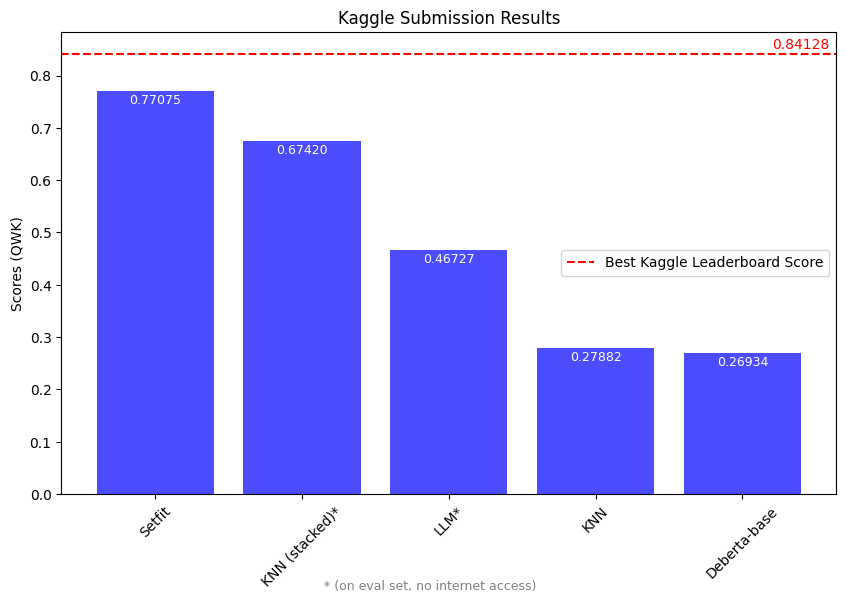

In [43]:
# Plotting with value labels and disclaimer
plt.figure(figsize=(10, 6))

best_kaggle = 0.84128

labels = ['Setfit', 'KNN (stacked)*', 'LLM*', 'KNN', 'Deberta-base']
scores = [0.77075, 0.6742, 0.46727, 0.27882, 0.26934]

bars = plt.bar(labels, scores, color='blue', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03, f'{bar.get_height():.5f}',
             ha='center', va='bottom', fontsize=9, color='white')

# Add horizontal dotted line for the Best Kaggle Leaderboard Score
plt.axhline(y=best_kaggle, color='red', linestyle='--', label='Best Kaggle Leaderboard Score')

# Add value label for the Best Kaggle score
plt.text(len(labels) - 0.6, best_kaggle + 0.01, f'{best_kaggle:.5f}', color='red', ha='center')

# Add labels and title
plt.ylabel('Scores (QWK)')
plt.title('Kaggle Submission Results')
plt.xticks(rotation=45)
plt.legend()

# Add disclaimer text
plt.figtext(0.6, -0.05, '* (on eval set, no internet access)', horizontalalignment='right', fontsize=9, color='gray')

plt.show()


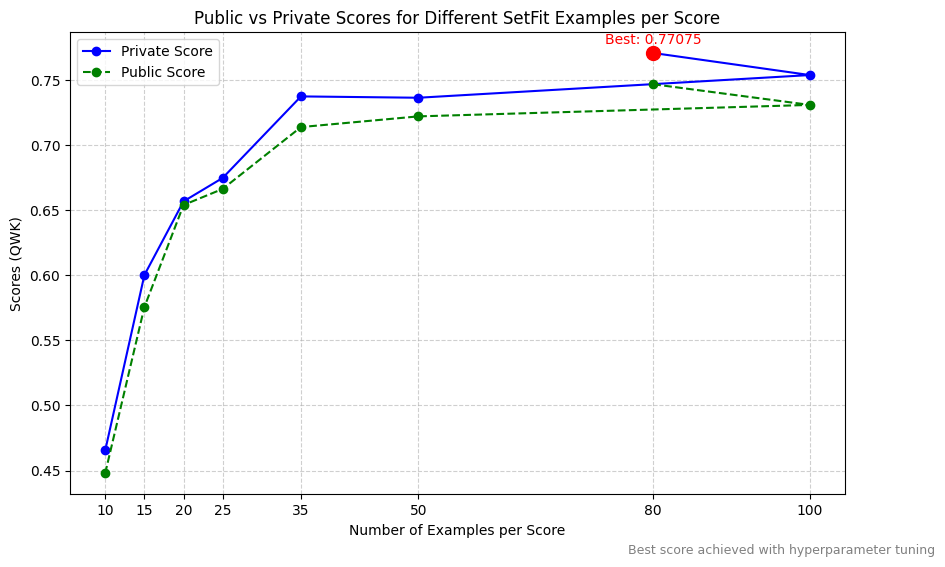

In [42]:
examples = [80, 100, 50, 35, 25, 20, 15, 10]
private_scores = [0.77075, 0.75381, 0.73638, 0.73741, 0.67478, 0.65678, 0.60017, 0.46561]
public_scores = [0.74675, 0.73087, 0.72207, 0.71385, 0.66633, 0.65399, 0.57562, 0.44813]

# Plotting with the best value highlighted and a disclaimer about hyperparameter tuning
plt.figure(figsize=(10, 6))
plt.plot(examples, private_scores, marker='o', linestyle='-', color='blue', label='Private Score')
plt.plot(examples, public_scores, marker='o', linestyle='--', color='green', label='Public Score')

# Highlighting the best value
best_score = max(private_scores)
best_example_index = private_scores.index(best_score)
plt.scatter(examples[best_example_index], best_score, color='red', s=100, zorder=5)
plt.text(examples[best_example_index], best_score + 0.007, f'Best: {best_score:.5f}', color='red', ha='center')

# Add labels and title
plt.xlabel('Number of Examples per Score')
plt.ylabel('Scores (QWK)')
plt.title('Public vs Private Scores for Different SetFit Examples per Score')
plt.xticks(examples)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Adding disclaimer
plt.figtext(0.99, 0.01, 'Best score achieved with hyperparameter tuning', horizontalalignment='right', fontsize=9, color='gray')

plt.show()